# 2-3. Support Vector Machine

- 기수:

- 이름:

- 작성자: 13기 한연주

_본 과제는 11기 김정우님, 12기 이정우님의 SVM 자료를 기반으로 만들었음을 밝힙니다._

간단한 SVM 실습을 Support Vector Machine의 개념과 Kernel SVM과 Naive SVM의 차이에 대해 이해해봅시다

총 2개의 문제가 있습니다. 코드를 잘 따라가면서 Q1, Q2를 차례대로 풀어보세요

### 01. Setting

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import datasets 

In [2]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

In [3]:
# Use pandas dataframe for visualization
# DataFrame 생성
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

# 출력 확인
print(df.shape)
df.head()

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


편의를 위해 본 과제에서는 mean radius와 mean texture 2개의 변수만을 이용해 유방 종양이 양성(benign)인지 악성(malignant)인지 판단하는 Binary Classification 문제로 간주한다.

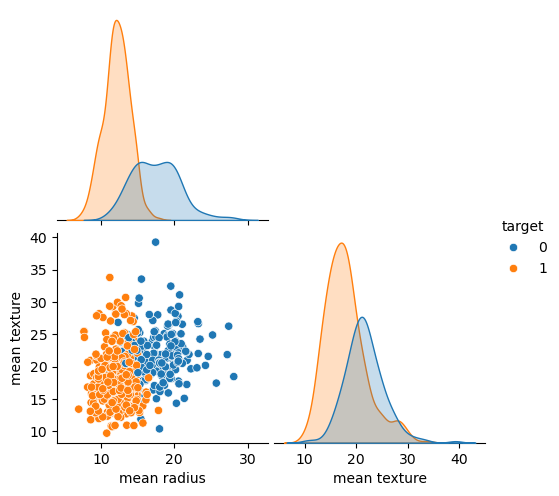

In [4]:
# 두 변수 간 시각화
sns.pairplot(df, vars=['mean radius', 'mean texture'], hue ='target', corner=True)
plt.show()

In [5]:
X = cancer.data[:, [0, 1]]  
y = cancer.target           # 0: malignant, 1: benign

print("Data Shape:", X.shape)

Data Shape: (569, 2)


### 02. Naive SVM

Q1. 2-2의 결과와 2-3의 알고리즘을 참조해서, 간단한 SVM을 직접 구현하라. 


In [6]:
class SimpleSVM:
    def __init__(self, learning_rate=0.001, C=0.0, n_iters=1000):
        self.learning_rate = learning_rate  # 학습률
        self.C = C                          # margin과 training error에 대한 trade-off를 결정하는 하이퍼파라미터
        self.n_iters = n_iters              # 반복 횟수
        self.w = None                       # 가중치 벡터
        self.b = None                       # 편향 값

    def fit(self, X, y):
        n_features = X.shape[1]
        y_ = y * 2 - 1  # 라벨을 -1, 1로 변환

        # 가중치와 편향 초기화
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                y_i = y_[idx]
                condition =  y_i * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w = self.w - self.learning_rate * self.w
                else:
                    self.w = self.w - self.learning_rate * (self.w - self.C * y_i * x_i)
                    self.b = self.b - self.learning_rate * (self.C * y_i)
                    
    def predict(self, X):
        approx = np.dot(X,self.w) - self.b
        predictions = np.sign(approx)
        return np.where(predictions == -1, 0, 1)

Q2. 모델을 학습한 test set에 대해 예측하고, accuracy 를 이용해 적절한 C를 선택하라. 이때 accuracy 92% 이상이어야 한다. (기본 C값=0)

In [7]:
# Train/Test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [13]:
C = 1
SVM = SimpleSVM(C=C)
SVM

In [14]:
# Model Training
SVM.fit(X_train, y_train)

# Prediction
y_pred = SVM.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM 모델의 정확도: {accuracy * 100:.2f}%")

SVM 모델의 정확도: 92.11%


결과를 시각적으로 확인해보자.

In [84]:
# Meshgrid function
def make_meshgrid(x, y, h=0.01):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# Countour function
def plot_contours(ax, model, xx, yy, **params):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [ ]:
# Contour plot
fig, sub = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

titles = ['SVM Train Set', 'SVM Test Set']
datasets = [(X_train, y_train), (X_test, y_test)]

for (X_set, y_set), title, ax in zip(datasets, titles, sub.flatten()):
    plot_contours(ax, SVM, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    scatter = ax.scatter(X_set[:, 0], X_set[:, 1], c=y_set, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Petal length')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig.colorbar(scatter, ax=sub, orientation='horizontal')
plt.show()